### Environment Setup

##### GPU config

In [0]:
"""
Runtime -> Change runtime type -> Hardware Accelorator (change from None to GPU)
Make sure there is no assertion error below
"""
%tensorflow_version 1.x
import tensorflow as tf
#assert tf.test.gpu_device_name() != '', "NO GPU DETECTED"


TensorFlow 1.x selected.


gdrive mount & add project directory

In [0]:
"""
Upload hyperbolic_nn folder to your Google drive root directory and run the following.
Authentication (in-browser) is required
"""
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/hyperbolic_nn')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Experiment

In [0]:
import os
import numpy as np
import pickle
import time
import random
from random import shuffle
import math
from datetime import datetime
import matplotlib.pyplot as plt


import util
import rnn_impl

In [0]:
epoch = 6

### arguments to change ###
"""
num_epochs: int 
word_dim: int
cell_type: 'rnn/gru/TFrnn/TFgru/TFlstm
geom: 'eucl/hyp'
hyp_opt: 'rsgd/projsgd
"""
base_name = "experiment_2d_hyp_rnn_rsgd"
root_path = '/content/gdrive/My Drive/hyperbolic_nn'
num_epochs = 6

is_spelling_corrected = True

word_dim = 2
hidden_dim = word_dim

cell_type = 'rnn'
geom = 'hyp'
hyp_opt = "rsgd"

lr_ffnn = 0.01
lr_words = 0.1
batch_size = 64

save_model = False
save_to_path = root_path+"/models/"+base_name

# Stopped at epoch 8
restore_model = True
restore_from_path = root_path +  "/2d_embedds/Rand_in_all_epochs_2/experiment_2d_hyp_rnn_rsgd_pretrain_poincare_glove_50_epoch_epoch_"+str(epoch)+"_it_0.ckpt"

pretrained = False
pretrained_path = root_path+"/Poincare_glove/2d_hyp_snli_embedds_poincare_glove"


In [0]:
### No need to change below ###
dtype = tf.float64

# Project setup
num_classes = 2

if is_spelling_corrected:
  snli_data_type = 'clean'
else:
  snli_data_type = 'dirty'

word_to_id_file_path = os.path.join(root_path, 'snli_dataset/', snli_data_type, 'word_to_id')
id_to_word_file_path = os.path.join(root_path, 'snli_dataset/', snli_data_type,'id_to_word')
suffix = '_' + str(num_classes) + 'class'
training_data_file_path = os.path.join(root_path, 'snli_dataset/', snli_data_type ,'train' + suffix)
test_data_file_path = os.path.join(root_path, 'snli_dataset/', snli_data_type ,'test' + suffix)
dev_data_file_path = os.path.join(root_path, 'snli_dataset/', snli_data_type ,'dev' + suffix)

PROJ_EPS = 1e-5
util.PROJ_EPS = PROJ_EPS
dataset = "SNLI"
c_val = 1.0

# FFNN params: id/relu/tanh/sigmoid
cell_non_lin = 'id'
ffnn_non_lin = 'id'

word_init_avg_norm = 0.001
additional_features = "dsq"

dropout = 1.0

sent_geom = geom
inputs_geom = geom
bias_geom = geom

ffnn_geom = geom
mlr_geom = geom

before_mlr_dim = word_dim

fix_biases = 'n'
fix_biases_str = ''
fix_matrices = 'n'
matrices_init_eye = 'n'
mat_str = ''

# Optimization params
burnin = 'n'

# L2 regularization
reg_beta = 0.0


if inputs_geom == 'hyp' or bias_geom == 'hyp' or ffnn_geom =='hyp' or mlr_geom == 'hyp':
    hyp_opt_str = hyp_opt + '_lrW' + str(lr_words) + '_lrFF' + str(lr_ffnn) + '_'
else:
    hyp_opt_str = ''

if c_val != 1.0:
    c_str = 'C'  + str(c_val) + '_'
else:
    c_str = ''

if dropout != 1.0:
    drp_str = 'drp' + str(dropout) + '_'
else:
    drp_str = ''

burnin_str = ''
if burnin:
    burnin_str = 'burn' + str(burnin).lower()

reg_beta_str = ''
if reg_beta > 0.0:
    reg_beta_str = 'reg' + str(reg_beta) + '_'

additional_features_str = additional_features
if additional_features != '':
    additional_features_str = additional_features + '_'

now = datetime.now()

tensorboard_name = base_name + '_' +\
                   dataset + '_' +\
                   'W' + str(word_dim) + 'd' + str(word_init_avg_norm) + 'init_' + \
                   cell_type + '_' + \
                   'cellNonL' + cell_non_lin + '_' +\
                   'SENT' + sent_geom + '_' + \
                   'INP' + inputs_geom + '_' + \
                   'BIAS' + bias_geom + fix_biases_str + '_' + mat_str +\
                   'FFNN' + ffnn_geom + str(before_mlr_dim) + ffnn_non_lin + '_' +\
                   additional_features_str + \
                   drp_str +\
                   'MLR' + mlr_geom + '_' + \
                   reg_beta_str + \
                   hyp_opt_str + \
                   c_str +\
                   'prje' + str(PROJ_EPS) + '_' + \
                   'bs' + str(batch_size) + '_' +\
                   burnin_str +  '__' + now.strftime("%H:%M:%S%dM")

name_experiment = tensorboard_name
logger = util.setup_logger(datetime.now().strftime("%Y%m%d-%H%:%M")+name_experiment+'.txt', logs_dir= os.path.join(root_path, 'logs/'), also_stdout=True)
logger.info('PARAMS :  ' + name_experiment)

2020/03/30 13:32:36: PARAMS :  experiment_2d_hyp_rnn_rsgd_SNLI_W2d0.001init_rnn_cellNonLid_SENThyp_INPhyp_BIAShyp_FFNNhyp2id_dsq_MLRhyp_rsgd_lrW0.1_lrFF0.01_prje1e-05_bs64_burnn__13:32:3630M


In [0]:
class HyperbolicRNNModel:
    def __init__(self, word_to_id, id_to_word):
        self.word_to_id = word_to_id
        self.id_to_word = id_to_word

        self.construct_placeholders()
        self.construct_execution_graph()


    def construct_placeholders(self):
        self.label_placeholder = tf.placeholder(tf.int32,
                                                shape=[batch_size],
                                                name='label_placeholder')

        self.word_ids_1 = tf.placeholder(tf.int32, shape=[batch_size, None],
                                         name='word_ids_1_placeholder')
        self.word_ids_2 = tf.placeholder(tf.int32, shape=[batch_size, None],
                                         name='word_ids_2_placeholder')

        self.num_words_1 = tf.placeholder(tf.int32, shape=[batch_size],
                                          name='num_words_1_placeholder')
        self.num_words_2 = tf.placeholder(tf.int32, shape=[batch_size],
                                          name='num_words_2_placeholder')

        self.burn_in_factor = tf.placeholder(dtype, name='burn_in_factor_placeholder')
        self.dropout_placeholder = tf.placeholder(dtype, name='dropout_placeholder')


    ###############################################################################################
    def construct_execution_graph(self):

        # Collect vars separately. Word embeddings are not used here.
        eucl_vars = []
        hyp_vars = []

        ################## word embeddings ###################

        # Initialize word embeddings close to 0, to have average norm equal to word_init_avg_norm.
        maxval = (3. * (word_init_avg_norm ** 2) / (2. * word_dim)) ** (1. / 3)
        initializer = tf.random_uniform_initializer(minval=-maxval, maxval=maxval, dtype=dtype)
        self.embeddings = tf.get_variable('embeddings',
                                          dtype=dtype,
                                          shape=[len(self.word_to_id), word_dim],
                                          initializer=initializer)

        if inputs_geom == 'eucl':
            eucl_vars += [self.embeddings]

        ################## RNNs for sentence embeddings ###################

        if cell_type == 'TFrnn':
            assert sent_geom == 'eucl'
            cell_class = lambda h_dim: tf.contrib.rnn.BasicRNNCell(h_dim)
        elif cell_type == 'TFgru':
            assert sent_geom == 'eucl'
            cell_class = lambda h_dim: tf.contrib.rnn.GRUCell(h_dim)
        elif cell_type == 'TFlstm':
            assert sent_geom == 'eucl'
            cell_class = lambda h_dim: tf.contrib.rnn.BasicLSTMCell(h_dim)
        elif cell_type == 'rnn' and sent_geom == 'eucl':
            cell_class = lambda h_dim: rnn_impl.EuclRNN(h_dim, dtype=dtype)
        elif cell_type == 'gru' and sent_geom == 'eucl':
            cell_class = lambda h_dim: rnn_impl.EuclGRU(h_dim, dtype=dtype)
        elif cell_type == 'rnn' and sent_geom == 'hyp':
            cell_class = lambda h_dim: rnn_impl.HypRNN(num_units=h_dim,
                                                       inputs_geom=inputs_geom,
                                                       bias_geom=bias_geom,
                                                       c_val=c_val,
                                                       non_lin=cell_non_lin,
                                                       fix_biases=fix_biases,
                                                       fix_matrices=fix_matrices,
                                                       matrices_init_eye=matrices_init_eye,
                                                       dtype=dtype)
        elif cell_type == 'gru' and sent_geom == 'hyp':
            cell_class = lambda h_dim: rnn_impl.HypGRU(num_units=h_dim,
                                                       inputs_geom=inputs_geom,
                                                       bias_geom=bias_geom,
                                                       c_val=c_val,
                                                       non_lin=cell_non_lin,
                                                       fix_biases=fix_biases,
                                                       fix_matrices=fix_matrices,
                                                       matrices_init_eye=matrices_init_eye,
                                                       dtype=dtype)
        else:
            logger.error('Not valid cell type: %s and sent_geom %s' % (cell_type, sent_geom))
            exit()

        # RNN 1
        with tf.variable_scope(cell_type + '1'):
            word_embeddings_1 = tf.nn.embedding_lookup(self.embeddings, self.word_ids_1) # bs x num_w_s1 x dim

            cell_1 = cell_class(hidden_dim)
            initial_state_1 = cell_1.zero_state(batch_size, dtype)
            outputs_1, state_1 = tf.nn.dynamic_rnn(cell=cell_1,
                                                   inputs=word_embeddings_1,
                                                   dtype=dtype,
                                                   initial_state=initial_state_1,
                                                   sequence_length=self.num_words_1)
            if cell_type == 'TFlstm':
                self.sent_1 = state_1[1]
            else:
                self.sent_1 = state_1


            sent1_norm = util.tf_norm(self.sent_1)


        # RNN 2
        with tf.variable_scope(cell_type + '2'):
            word_embeddings_2 = tf.nn.embedding_lookup(self.embeddings, self.word_ids_2)
            # tf.summary.scalar('word_emb2', tf.reduce_mean(tf.norm(word_embeddings_2, axis=2)))

            cell_2 = cell_class(hidden_dim)
            initial_state_2 = cell_2.zero_state(batch_size, dtype)
            outputs_2, state_2 = tf.nn.dynamic_rnn(cell=cell_2,
                                                   inputs=word_embeddings_2,
                                                   dtype=dtype,
                                                   initial_state=initial_state_2,
                                                   sequence_length=self.num_words_2)
            if cell_type == 'TFlstm':
                self.sent_2 = state_2[1]
            else:
                self.sent_2 = state_2


            sent2_norm = util.tf_norm(self.sent_2)


        tf.summary.scalar('RNN/word_emb1', tf.reduce_mean(tf.norm(word_embeddings_1, axis=2)))
        tf.summary.scalar('RNN/sent1', tf.reduce_mean(sent1_norm))
        tf.summary.scalar('RNN/sent2', tf.reduce_mean(sent2_norm))


        eucl_vars += cell_1.eucl_vars + cell_2.eucl_vars
        if sent_geom == 'hyp':
            hyp_vars += cell_1.hyp_vars + cell_2.hyp_vars

 
        ## Compute d(s1, s2)
        if sent_geom == 'eucl':
            d_sq_s1_s2 = util.tf_euclid_dist_sq(self.sent_1, self.sent_2)
        else:
            d_sq_s1_s2 = util.tf_poinc_dist_sq(self.sent_1, self.sent_2, c = c_val)


        ##### Some summaries:

        # For summaries and debugging, we need these:
        pos_labels = tf.reshape(tf.cast(self.label_placeholder, tf.float64), [-1, 1])
        neg_labels = 1. - pos_labels
        weights_pos_labels = pos_labels / tf.reduce_sum(pos_labels)
        weights_neg_labels = neg_labels / tf.reduce_sum(neg_labels)

        ################## first feed forward layer ###################

        # Define variables for the first feed-forward layer: W1 * s1 + W2 * s2 + b + bd * d(s1,s2)
        W_ff_s1 = tf.get_variable('W_ff_s1',
                                  dtype=dtype,
                                  shape=[hidden_dim, before_mlr_dim],
                                  initializer= tf.contrib.layers.xavier_initializer())

        W_ff_s2 = tf.get_variable('W_ff_s2',
                                  dtype=dtype,
                                  shape=[hidden_dim, before_mlr_dim],
                                  initializer= tf.contrib.layers.xavier_initializer())

        b_ff = tf.get_variable('b_ff',
                               dtype=dtype,
                               shape=[1, before_mlr_dim],
                               initializer=tf.constant_initializer(0.0))

        b_ff_d = tf.get_variable('b_ff_d',
                                 dtype=dtype,
                                 shape=[1, before_mlr_dim],
                                 initializer=tf.constant_initializer(0.0))

        eucl_vars += [W_ff_s1, W_ff_s2]
        if ffnn_geom == 'eucl' or bias_geom == 'eucl':
            eucl_vars += [b_ff]
            if additional_features == 'dsq':
                eucl_vars += [b_ff_d]
        else:
            hyp_vars += [b_ff]
            if additional_features == 'dsq':
                hyp_vars += [b_ff_d]


        if ffnn_geom == 'eucl' and sent_geom == 'hyp': # Sentence embeddings are Euclidean after log, except the proper distance (Eucl or hyp) is kept!
            self.sent_1 = util.tf_log_map_zero(self.sent_1, c_val)
            self.sent_2 = util.tf_log_map_zero(self.sent_2, c_val)

        ####### Build output_ffnn #######
        if ffnn_geom == 'eucl':
            output_ffnn = tf.matmul(self.sent_1, W_ff_s1) + tf.matmul(self.sent_2, W_ff_s2) + b_ff
            if additional_features == 'dsq': # [u, v, d(u,v)^2]
                output_ffnn = output_ffnn + d_sq_s1_s2 * b_ff_d

        else:
            assert sent_geom == 'hyp'
            ffnn_s1 = util.tf_mob_mat_mul(W_ff_s1, self.sent_1, c_val)
            ffnn_s2 = util.tf_mob_mat_mul(W_ff_s2, self.sent_2, c_val)
            output_ffnn = util.tf_mob_add(ffnn_s1, ffnn_s2, c_val)

            hyp_b_ff = b_ff
            if bias_geom == 'eucl':
                hyp_b_ff = util.tf_exp_map_zero(b_ff, c_val)
            output_ffnn = util.tf_mob_add(output_ffnn, hyp_b_ff, c_val)

            if additional_features == 'dsq': # [u, v, d(u,v)^2]
                hyp_b_ff_d = b_ff_d
                if bias_geom == 'eucl':
                    hyp_b_ff_d = util.tf_exp_map_zero(b_ff_d, c_val)

                output_ffnn = util.tf_mob_add(output_ffnn,
                                              util.tf_mob_scalar_mul(d_sq_s1_s2, hyp_b_ff_d, c_val),
                                              c_val)

        if ffnn_geom == 'eucl':
            output_ffnn = util.tf_eucl_non_lin(output_ffnn, non_lin=ffnn_non_lin)
        else:
            output_ffnn = util.tf_hyp_non_lin(output_ffnn,
                                              non_lin=ffnn_non_lin,
                                              hyp_output = (mlr_geom == 'hyp' and dropout == 1.0),
                                              c=c_val)
        # Mobius dropout
        if dropout < 1.0:
            # If we are here, then output_ffnn should be Euclidean.
            output_ffnn = tf.nn.dropout(output_ffnn, keep_prob=self.dropout_placeholder)
            if (mlr_geom == 'hyp'):
                output_ffnn = util.tf_exp_map_zero(output_ffnn, c_val)


        ################## MLR ###################
        # output_ffnn is batch_size x before_mlr_dim

        A_mlr = []
        P_mlr = []
        logits_list = []
        for cl in range(num_classes):
            A_mlr.append(tf.get_variable('A_mlr' + str(cl),
                                         dtype=dtype,
                                         shape=[1, before_mlr_dim],
                                         initializer=tf.contrib.layers.xavier_initializer()))
            eucl_vars += [A_mlr[cl]]

            P_mlr.append(tf.get_variable('P_mlr' + str(cl),
                                         dtype=dtype,
                                         shape=[1, before_mlr_dim],
                                         initializer=tf.constant_initializer(0.0)))

            if mlr_geom == 'eucl':
                eucl_vars += [P_mlr[cl]]
                logits_list.append(tf.reshape(util.tf_dot(-P_mlr[cl] + output_ffnn, A_mlr[cl]), [-1]))

            elif mlr_geom == 'hyp':
                hyp_vars += [P_mlr[cl]]
                minus_p_plus_x = util.tf_mob_add(-P_mlr[cl], output_ffnn, c_val)
                norm_a = util.tf_norm(A_mlr[cl])
                lambda_px = util.tf_lambda_x(minus_p_plus_x, c_val)
                px_dot_a = util.tf_dot(minus_p_plus_x, tf.nn.l2_normalize(A_mlr[cl]))
                logit = 2. / np.sqrt(c_val) * norm_a * tf.asinh(np.sqrt(c_val) * px_dot_a * lambda_px)
                logits_list.append(tf.reshape(logit, [-1]))

        self.logits = tf.stack(logits_list, axis=1)

        self.argmax_idx = tf.argmax(self.logits, axis=1, output_type=tf.int32)

        self.loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.label_placeholder,
                                                           logits=self.logits))
        tf.summary.scalar('classif/unreg_loss', self.loss)

        if reg_beta > 0.0:
            assert num_classes == 2
            distance_regularizer = tf.reduce_mean(
                (tf.cast(self.label_placeholder, dtype=dtype) - 0.5) * d_sq_s1_s2)

            self.loss = self.loss + reg_beta * distance_regularizer

        self.acc = tf.reduce_mean(tf.to_float(tf.equal(self.argmax_idx, self.label_placeholder)))
        tf.summary.scalar('classif/accuracy', self.acc)




        ######################################## OPTIMIZATION ######################################
        all_updates_ops = []

        ###### Update Euclidean parameters using Adam.
        optimizer_euclidean_params = tf.train.AdamOptimizer(learning_rate=1e-3)
        eucl_grads = optimizer_euclidean_params.compute_gradients(self.loss, eucl_vars)
        capped_eucl_gvs = [(tf.clip_by_norm(grad, 1.), var) for grad, var in eucl_grads]  ###### Clip gradients
        all_updates_ops.append(optimizer_euclidean_params.apply_gradients(capped_eucl_gvs))


        ###### Update Hyperbolic parameters, i.e. word embeddings and some biases in our case.
        def rsgd(v, riemannian_g, learning_rate):
            if hyp_opt == 'rsgd':
                return util.tf_exp_map_x(v, -self.burn_in_factor * learning_rate * riemannian_g, c=c_val)
            else:
                # Use approximate RSGD based on a simple retraction.
                updated_v = v - self.burn_in_factor * learning_rate * riemannian_g
                # Projection op after SGD update. Need to make sure embeddings are inside the unit ball.
                return util.tf_project_hyp_vecs(updated_v, c_val)


        if inputs_geom == 'hyp':
            grads_and_indices_hyp_words = tf.gradients(self.loss, self.embeddings)
            grads_hyp_words = grads_and_indices_hyp_words[0].values
            repeating_indices = grads_and_indices_hyp_words[0].indices
            unique_indices, idx_in_repeating_indices = tf.unique(repeating_indices)
            agg_gradients = tf.unsorted_segment_sum(grads_hyp_words,
                                                    idx_in_repeating_indices,
                                                    tf.shape(unique_indices)[0])

            agg_gradients = tf.clip_by_norm(agg_gradients, 1.) ######## Clip gradients
            unique_word_emb = tf.nn.embedding_lookup(self.embeddings, unique_indices)  # no repetitions here

            riemannian_rescaling_factor = util.riemannian_gradient_c(unique_word_emb, c=c_val)
            rescaled_gradient = riemannian_rescaling_factor * agg_gradients

            all_updates_ops.append(tf.scatter_update(self.embeddings,
                                                     unique_indices,
                                                     rsgd(unique_word_emb, rescaled_gradient, lr_words))) # Updated rarely

        if len(hyp_vars) > 0:
            hyp_grads = tf.gradients(self.loss, hyp_vars)
            capped_hyp_grads = [tf.clip_by_norm(grad, 1.) for grad in hyp_grads]  ###### Clip gradients


            for i in range(len(hyp_vars)):
                riemannian_rescaling_factor = util.riemannian_gradient_c(hyp_vars[i], c=c_val)
                rescaled_gradient = riemannian_rescaling_factor * capped_hyp_grads[i]
                all_updates_ops.append(tf.assign(hyp_vars[i], rsgd(hyp_vars[i], rescaled_gradient, lr_ffnn)))  # Updated frequently

        self.all_optimizer_var_updates_op = tf.group(*all_updates_ops)


        self.summary_merged = tf.summary.merge_all()
        self.test_summary_writer = tf.summary.FileWriter(
            os.path.join(root_path, 'tb_28may/' + tensorboard_name + '/'))


    ###############################################################################################
    ###############################################################################################
    ###############################################################################################
    def test(self, sess, test_or_valid_data, name, summary_i):
        N = len(test_or_valid_data)
        i = 0
        predictions = []

        avg_loss = 0.0
        num_b_in_loss = 0
        while i < N:
            batch_word_ids_1, batch_num_words_1, batch_word_ids_2, batch_num_words_2, batch_label = self.next_batch(
                i=i, N=N, data=test_or_valid_data)

            if name == 'test':
                summary, loss, argmax_idx = \
                    sess.run([self.summary_merged, self.loss, self.argmax_idx], feed_dict={
                        self.word_ids_1: batch_word_ids_1,
                        self.num_words_1: batch_num_words_1,
                        self.word_ids_2: batch_word_ids_2,
                        self.num_words_2: batch_num_words_2,
                        self.label_placeholder: batch_label,
                        self.dropout_placeholder: 1.0
                    })
                self.test_summary_writer.add_summary(summary, summary_i)

            else:
                loss, argmax_idx = \
                    sess.run([self.loss, self.argmax_idx], feed_dict={
                        self.word_ids_1: batch_word_ids_1,
                        self.num_words_1: batch_num_words_1,
                        self.word_ids_2: batch_word_ids_2,
                        self.num_words_2: batch_num_words_2,
                        self.label_placeholder: batch_label,
                        self.dropout_placeholder: 1.0
                    })

            avg_loss += loss
            num_b_in_loss += 1

            for ci in argmax_idx:
                predictions.append(ci)

            i += batch_size

        avg_loss /= num_b_in_loss

        num_correct = 0.0
        glE_predE = 0.0
        glN_predN = 0.0
        glE_predN = 0.0
        glN_predE = 0.0

        predictions = predictions[:N]

        for ind, predicted_label in enumerate(predictions):
            gold_label = test_or_valid_data[ind][4]

            if predicted_label == gold_label:
                num_correct += 1.0
                if predicted_label == 1:
                    glE_predE += 1.0
                else:
                    glN_predN += 1.0
            else:
                if predicted_label == 1:
                    glN_predE += 1.0
                else:
                    glE_predN += 1.0

        accuracy = num_correct / (1.0 * N)

        if name == 'test':
            logger.info('For ' + name + ': ==> ' +
                        ' glN_predN = ' + str(glN_predN) + '; glE_predN = ' + str(glE_predN) +
                        '; glN_predE = ' + str(glN_predE) + '; glE_predE = ' + str(glE_predE))

        return accuracy


    def next_batch(self, i, N, data):
        it = i
        to = min(i + batch_size, N)

        MAX_PAD = 0
        batch_word_ids_1 = []
        batch_num_words_1 = []

        batch_word_ids_2 = []
        batch_num_words_2 = []

        batch_label = []

        while it < to:
            word_ids_1 = data[it][0]
            num_words_1 = data[it][1]
            word_ids_2 = data[it][2]
            num_words_2 = data[it][3]
            label = data[it][4]

            MAX_PAD = max(MAX_PAD, max(len(word_ids_1), len(word_ids_2)))

            batch_word_ids_1.append(word_ids_1)
            batch_num_words_1.append(num_words_1)

            batch_word_ids_2.append(word_ids_2)
            batch_num_words_2.append(num_words_2)

            batch_label.append(label)

            it += 1

            if it == to and to == N:
                it = 0
                to = batch_size - len(batch_word_ids_1)

        for ind in range(0, batch_size):

            while len(batch_word_ids_1[ind]) < MAX_PAD:
                batch_word_ids_1[ind].append(0)

            while len(batch_word_ids_2[ind]) < MAX_PAD:
                batch_word_ids_2[ind].append(0)

            if len(batch_word_ids_1[ind]) != MAX_PAD or len(batch_word_ids_2[ind]) != MAX_PAD:
                logger.error('THIS IS WRONG!: len1: %d\nlen2: %d\nMAX_PAD:%d\n' %
                             (len(batch_word_ids_1[ind]), len(batch_word_ids_2[ind]), MAX_PAD))
                exit()

        batch_word_ids_1 = np.array(batch_word_ids_1)
        batch_num_words_1 = np.array(batch_num_words_1)

        batch_word_ids_2 = np.array(batch_word_ids_2)
        batch_num_words_2 = np.array(batch_num_words_2)
        batch_label = np.array(batch_label)

        return batch_word_ids_1, batch_num_words_1, batch_word_ids_2, batch_num_words_2, batch_label


    def dataset_to_minibatches(self, dataset):
        N = len(dataset)
        i = 0
        batches_list = []
        while i < N:
            batches_list.append(self.next_batch(i=i, N=N, data=dataset))
            i += batch_size
        return batches_list


    def train(self, training_data, dev_data, test_data, restore_model=False, save_model=False,
              restore_from_path=None, save_to_path=None):

        training_data_batches = self.dataset_to_minibatches(training_data)
        num_batches = len(training_data_batches)
        N = len(training_data)

        saver = tf.train.Saver()
        best_test_accuracy = 0.0
        best_validation_accuracy = 0.0
        best_i = 0

        PRINT_STEP = 2000

        config = tf.ConfigProto(
            intra_op_parallelism_threads=5,
            inter_op_parallelism_threads=3,
            log_device_placement=True
        )
        config.gpu_options.allow_growth = True
        with tf.Session(config=config) as sess:

            sess.run(tf.global_variables_initializer())
            in_embeds = self.embeddings.eval()

            if restore_model:
                saver.restore(sess, restore_from_path)
            else:
                sess.run(tf.global_variables_initializer())

            sess.graph.finalize()

            trained_embeds = self.embeddings.eval()

            return in_embeds,trained_embeds


            # Uncomment after

        #     burn_in_factor = 1.0
        #     epoch = -1
        #     while epoch < num_epochs:
        #         epoch += 1
        #         logger.info('Epoch: %d' % epoch)

        #         cur_total_time = 0
        #         shuffle(training_data_batches) # Shuffle training data after each epoch.

        #         if burnin and epoch == 0:
        #             burn_in_factor /= 10.0
        #         i = -1
        #         while i < num_batches - 1:
        #             i += 1

        #             # Training
        #             batch_word_ids_1, batch_num_words_1, \
        #             batch_word_ids_2, batch_num_words_2, \
        #             batch_label = training_data_batches[i]

        #             feed_dict = {
        #                 self.word_ids_1: batch_word_ids_1,
        #                 self.num_words_1: batch_num_words_1,
        #                 self.word_ids_2: batch_word_ids_2,
        #                 self.num_words_2: batch_num_words_2,
        #                 self.label_placeholder: batch_label,
        #                 self.burn_in_factor: burn_in_factor,
        #                 self.dropout_placeholder: dropout
        #             }

        #             sess_time_start = time.time()
        #             curr_loss, _ = sess.run([self.loss, self.all_optimizer_var_updates_op], feed_dict=feed_dict)
        #             cur_total_time += time.time() - sess_time_start

        #             if i % PRINT_STEP == 0:
        #                 if i > 0:
        #                     avg_sec_per_sent = cur_total_time / (PRINT_STEP * batch_size)
        #                     logger.info('Num examples processed: %d. curr_loss: %.4f; sec_per_sent: %.4f' % (
        #                         epoch * N + i * batch_size, curr_loss, avg_sec_per_sent))
        #                 cur_total_time = 0


        #                 # Testing
        #                 validation_accuracy = self.test(sess,
        #                                                 dev_data,
        #                                                 'validation',
        #                                                 epoch * N + i * batch_size)
        #                 test_accuracy = self.test(sess,
        #                                           test_data,
        #                                           'test',
        #                                           epoch * N + i * batch_size)
        #                 logger.info('CURRENT val accuracy: %.4f ; test accuracy: \033[92m %.4f \033[0m' %
        #                             (validation_accuracy, test_accuracy))

        #                 if validation_accuracy > best_validation_accuracy:
        #                     best_validation_accuracy = validation_accuracy
        #                     best_test_accuracy = test_accuracy
        #                     best_i = epoch * N + i * batch_size

        #                 logger.info(('BEST: i = %d, val acc: ' + '\033[94m' + ' %.2f' + '\033[0m' +
        #                              ', test acc: ' + '\033[91m' + ' %.2f' + '\033[0m') %
        #                             (best_i, 100 * best_validation_accuracy, 100 * best_test_accuracy))

        #                 if save_model:
        #                     store_time_begin = time.time()
        #                     saver.save(sess, '%s_epoch_%d_it_%d.ckpt' % (save_to_path, epoch, i))
        #                     logger.info('Stored the model in %d seconds.' %
        #                                 (time.time() - store_time_begin))

        #                 logger.info('EXPERIMENT = ' + name_experiment)
        #                 logger.info('=============================================================')

        #             if np.isinf(curr_loss) or np.isnan(curr_loss):
        #                 logger.error('At example ' + str(epoch * N + i * batch_size) +
        #                              '; curr_loss: ' + str(curr_loss))
        #                 exit()


        # logger.info(('DONE -- BEST: i = %d, val acc: ' + '\033[94m' + ' %.2f' + '\033[0m' +
        #              ', test acc: ' + '\033[91m' + ' %.2f' + '\033[0m') %
        #             (best_i, 100 * best_validation_accuracy, 100 * best_test_accuracy))


def get_datasets():
    logger.info('Loading train - val - test data')

    test_data = pickle.load(open(test_data_file_path, 'rb'))
    dev_data = pickle.load(open(dev_data_file_path, 'rb'))
    training_data = pickle.load(open(training_data_file_path, 'rb'))

    logger.info('Training data size: %d' % len(training_data))
    class_to_count = {1: 0.0, 0: 0.0}
    for i in range(len(training_data)):
        class_to_count[training_data[i][4]] += 1.0
    for cl in class_to_count:
        logger.info('Class %d has %.4f percent samples' % (cl, 100. * class_to_count[cl] / len(training_data)))

    logger.info('Validation data size: %d' % len(dev_data))
    class_to_count = {1: 0.0, 0: 0.0}
    for i in range(len(test_data)):
        class_to_count[test_data[i][4]] += 1.0
    for cl in class_to_count:
        logger.info('Class %d has %.4f percent samples' % (cl, 100. * class_to_count[cl] / len(dev_data)))

    logger.info('Test data size: %d' % len(test_data))
    class_to_count = {1: 0.0, 0: 0.0}
    for i in range(len(test_data)):
        class_to_count[test_data[i][4]] += 1.0
    for cl in class_to_count:
        logger.info('Class %d has %.4f percent samples' % (cl, 100. * class_to_count[cl] / len(test_data)))

    return training_data, dev_data, test_data


def run():
    word_to_id = pickle.load(open(word_to_id_file_path, 'rb'))
    id_to_word = pickle.load(open(id_to_word_file_path, 'rb'))

    model = HyperbolicRNNModel(word_to_id=word_to_id,
                               id_to_word=id_to_word)

    training_data, dev_data, test_data = get_datasets()

    in_embeds,trained_embeds = model.train(training_data=training_data,
                                            dev_data=dev_data,
                                            test_data=test_data,
                                            save_model=save_model,
                                            save_to_path=save_to_path,
                                            restore_model=restore_model,
                                            restore_from_path=restore_from_path)

    return in_embeds,trained_embeds

if __name__=='__main__':
  in_embeds,trained_embeds = run()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Init RNN cell
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Init RNN cell
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.cast` instead.


2020/03/30 13:32:46: Loading train - val - test data
2020/03/30 13:32:49: Training data size: 549367
2020/03/30 13:32:49: Class 1 has 33.3868 percent samples
2020/03/30 13:32:49: Class 0 has 66.6132 percent samples
2020/03/30 13:32:49: Validation data size: 9842
2020/03/30 13:32:49: Class 1 has 34.2207 percent samples
2020/03/30 13:32:49: Class 0 has 65.5964 percent samples
2020/03/30 13:32:49: Test data size: 9824
2020/03/30 13:32:49: Class 1 has 34.2834 percent samples
2020/03/30 13:32:49: Class 0 has 65.7166 percent samples


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/hyperbolic_nn/2d_embedds/Rand_in_all_epochs_2/experiment_2d_hyp_rnn_rsgd_pretrain_poincare_glove_50_epoch_epoch_6_it_0.ckpt


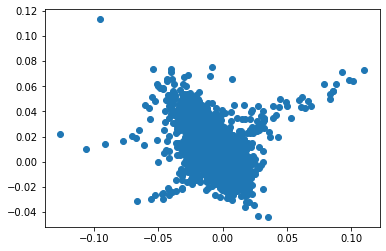

In [0]:

fig = plt.figure()
plt.scatter(trained_embeds[:,0], trained_embeds[:,1])
plt.show()

In [0]:
root_path = '/content/gdrive/My Drive/hyperbolic_nn'

# np.savetxt(root_path+"/rand_in_hyperbolic_dim_2.txt", in_embeds,delimiter=',')
np.savetxt(root_path+"/2d_embedds/Rand_in_all_epochs/rand_in_hyperbolic_dim_2_epoch_"+str(epoch+25)+".txt", trained_embeds,delimiter=',')
